In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc       

rc('font', family='NanumGothic')               
plt.rcParams['axes.unicode_minus'] = False

- LNG 연료투입량 데이터는 비공개이므로, 직접 확보할 수 없다. 따라서 이를 수식적 접근이나 모델링 기법을 활용해 추정·생성해야 한다.

- 현재 확보한 데이터는

    1. 시간별 전기 및 열 생산량(두 달치)

    2. 월 단위 연료 사용량 통계
이 두 가지임

- 그러므로 월 단위 연료 사용량을 시간 단위로 분해(증강)하는 방식으로 시간별 연료 투입량 데이터를 생성한다.

- 기본 원리는 간단하다.

    1. 전기 생산량 + 열 생산량 = 총 에너지 산출량이라고 가정한다.

    2. 이를 바탕으로, 시간별 산출량의 비중을 계산하고, 월별 총 연료 사용량을 이 비중에 따라 배분한다.

- 아래 공식에 따라 증강된 시간 단위 연료 투입량 데이터를 얻을 수 있다.

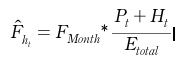

---
1. 단위 맞추기
- 연료사용량(LNG)단위 : Nm^3 -> MW 로 단위 맞춰주려면  10,800 kcal/Nm³ ≈ 10.8 kWh/Nm³ ≈ 0.0108 MWh/Nm³인 저위발열량 수치 10,800을 곱해서 처리해준다.
- 전기 생산량() : MW 
- 열 생산량 단위 : Gcal[MW로 맞춰주려면 1.163 을 곱해줘야 함]

In [2]:
df2 = pd.read_csv("/mnt/nvme/CHP_data/한국지역난방공사 발전소 연료사용 통계_20220228.csv", encoding="cp949")

In [26]:
df2[(df2["지사"]=="판교")]

,지사,연료,단위,2015년 1월,2015년 2월,2015년 3월,2015년 4월,2015년 5월,2015년 6월,2015년 7월,...,2021년 5월,2021년 6월,2021년 7월,2021년 8월,2021년 9월,2021년 10월,2021년 11월,2021년 12월,2022년 1월,2022년 2월
91,판교,LSWR,ℓ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,판교,B.C,ℓ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,판교,LNG,N㎥,25276501.0,20728138.0,20789737.0,17807958.0,16405936.0,5510671.0,13371648.0,...,21263900.0,1997764.0,10985694.0,10062819.0,8139982.0,15539526.0,23935496.0,25666595.0,26007369.0,22261376.0
94,판교,LFG,N㎥,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,판교,등유,ℓ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,판교,우드칩,Kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,판교,바이오가스,N㎥,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df2_1 = df2[(df2["지사"]=="강남") & (df2["연료"]=="LNG")]

df22 = pd.melt(
    df2_1,
    id_vars=["지사", "연료", "단위"],
    var_name="month",            # 월 정보 (ex: 2021년 10월)
    value_name="연료투입량"       # 값: 연료사용량
)

# 문자열 정리
df22["month"] = df22["month"].str.replace("년", "-", regex=False)
df22["month"] = df22["month"].str.replace("월", "", regex=False)
df22["month"] = df22["month"].str.replace(" ", "", regex=False)

df22["month"] = pd.to_datetime(df22["month"], format="%Y-%m")

# 원하는 기간 필터링
df22_filter = df22[(df22["month"] >= "2021-10-01") & (df22["month"] <= "2021-11-30")]


In [46]:
df22.set_index("month", inplace=True)

,지사,연료,단위,연료투입량
month,,,,
2016-08-01,강남,LNG,N㎥,NaN
2020-04-01,강남,LNG,N㎥,NaN
2020-06-01,강남,LNG,N㎥,NaN
2020-08-01,강남,LNG,N㎥,NaN
2021-09-01,강남,LNG,N㎥,NaN


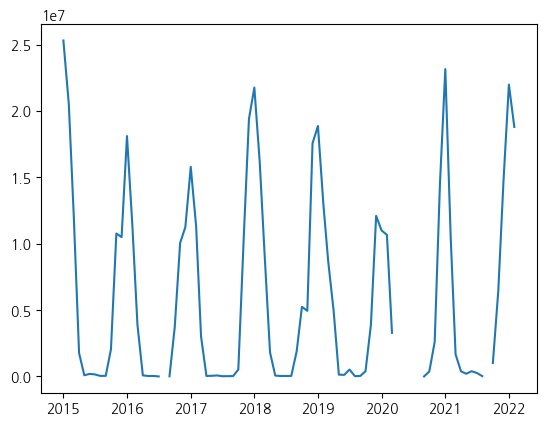

In [47]:
plt.plot(df22["연료투입량"]) # 끊겨 있는 부분은 연에 한번씩 있는 정기점검 - 해당 NA가 왜 발생했는지는 
df22[pd.isna(df22["연료투입량"])]

In [30]:
heat_produce = pd.read_csv("/mnt/nvme/CHP_data/process/시간단위_열_생산량.csv") # 단위가 Gcal
electric_produce = pd.read_csv("/mnt/nvme/CHP_data/process/시간단위_전기_생산량.csv") # 단위가 MW

In [31]:
heat_produce

,Unnamed: 0,time,단위(열생산),파주,고양,삼송,중앙,강남,판교,분당,용인,광교,수원,화성,동탄,평택
0,0,2021-10-01 01:00:00,Gcal,6.0,25.0,3.0,59.0,53.0,4.0,32.0,5.0,0.0,57.0,6.0,24.0,2.7
1,1,2021-10-01 02:00:00,Gcal,7.0,26.0,3.0,59.0,52.0,0.0,33.0,4.0,0.0,64.0,0.0,25.0,2.3
2,2,2021-10-01 03:00:00,Gcal,6.0,25.0,4.0,59.0,54.0,0.0,32.0,4.0,0.0,62.0,0.0,23.0,2.2
3,3,2021-10-01 04:00:00,Gcal,7.0,26.0,4.0,55.0,52.0,0.0,28.0,4.0,0.0,65.0,0.0,24.0,2.0
4,4,2021-10-01 05:00:00,Gcal,6.0,26.0,4.0,57.0,53.0,0.0,32.0,4.0,0.0,64.0,1.0,23.0,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,1459,2021-11-30 20:00:00,Gcal,378.0,231.0,5.0,171.0,342.0,169.0,323.7,4.0,129.0,36.0,398.0,453.0,15.0
1460,1460,2021-11-30 21:00:00,Gcal,379.0,231.0,5.0,172.0,405.0,172.0,322.7,4.0,130.0,36.0,405.0,414.0,14.0
1461,1461,2021-11-30 22:00:00,Gcal,379.0,205.0,6.0,171.0,414.0,168.0,322.7,4.0,129.0,34.0,405.0,435.0,15.0
1462,1462,2021-11-30 23:00:00,Gcal,379.0,204.0,5.0,171.0,433.0,168.0,319.7,4.0,129.0,35.0,405.0,467.0,14.0


In [32]:
electric_produce

,Unnamed: 0,time,단위(전기생산),파주.1,고양.1,삼송.1,중앙.1,강남.1,판교.1,분당.1,용인.1,광교.1,수원.1,화성.1,동탄.1,평택.1
0,0,2021-10-01 01:00:00,MWh,0.0,0.0,0.0,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,543.0,0.0
1,1,2021-10-01 02:00:00,MWh,0.0,0.0,0.0,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,456.0,0.0
2,2,2021-10-01 03:00:00,MWh,0.0,0.0,0.0,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,457.0,0.0
3,3,2021-10-01 04:00:00,MWh,0.0,0.0,0.0,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,456.0,0.0
4,4,2021-10-01 05:00:00,MWh,0.0,0.0,0.0,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,456.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,1459,2021-11-30 20:00:00,MWh,491.0,0.0,0.0,0.0,42.0,151.0,0.0,0.0,161.0,0.0,489.0,622.0,0.0
1460,1460,2021-11-30 21:00:00,MWh,492.0,0.0,0.0,0.0,42.0,152.0,0.0,0.0,162.0,0.0,494.0,557.0,0.0
1461,1461,2021-11-30 22:00:00,MWh,493.0,0.0,0.0,0.0,42.0,152.0,0.0,0.0,162.0,0.0,494.0,646.0,0.0
1462,1462,2021-11-30 23:00:00,MWh,494.0,0.0,0.0,0.0,42.0,153.0,0.0,0.0,163.0,0.0,494.0,710.0,0.0


In [8]:
heat_produce["time"] = pd.to_datetime(heat_produce["time"])
electric_produce["time"] = pd.to_datetime(electric_produce["time"])

# 
electric_produce.set_index("time", inplace=True)
heat_produce.set_index("time", inplace=True)

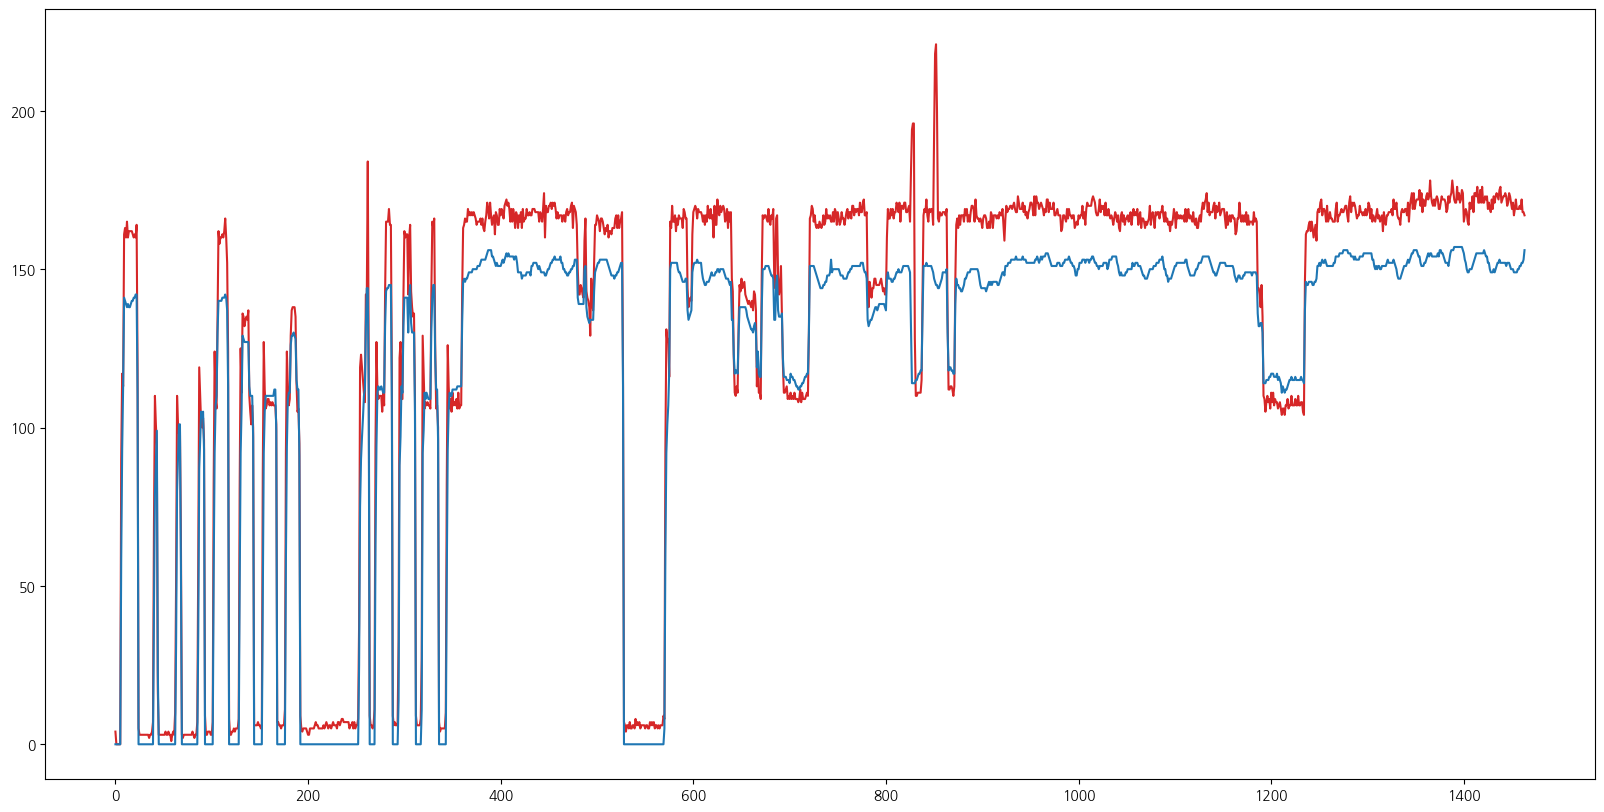

In [33]:
plt.figure(figsize=(20,10))
plt.plot(heat_produce["판교"], color="tab:red")
plt.plot(electric_produce["판교.1"])

In [42]:
# 
electric_produce.index = pd.to_datetime(electric_produce.index)
heat_produce.index = pd.to_datetime(heat_produce.index)


In [43]:
electric_produce

,Unnamed: 0,단위(전기생산),파주.1,고양.1,삼송.1,중앙.1,강남.1,판교.1,분당.1,용인.1,광교.1,수원.1,화성.1,동탄.1,평택.1
time,,,,,,,,,,,,,,,
2021-10-01 01:00:00,0,MWh,0.0,0.0,0.0,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,543.0,0.0
2021-10-01 02:00:00,1,MWh,0.0,0.0,0.0,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,456.0,0.0
2021-10-01 03:00:00,2,MWh,0.0,0.0,0.0,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,457.0,0.0
2021-10-01 04:00:00,3,MWh,0.0,0.0,0.0,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,456.0,0.0
2021-10-01 05:00:00,4,MWh,0.0,0.0,0.0,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,456.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30 20:00:00,1459,MWh,491.0,0.0,0.0,0.0,42.0,151.0,0.0,0.0,161.0,0.0,489.0,622.0,0.0
2021-11-30 21:00:00,1460,MWh,492.0,0.0,0.0,0.0,42.0,152.0,0.0,0.0,162.0,0.0,494.0,557.0,0.0
2021-11-30 22:00:00,1461,MWh,493.0,0.0,0.0,0.0,42.0,152.0,0.0,0.0,162.0,0.0,494.0,646.0,0.0


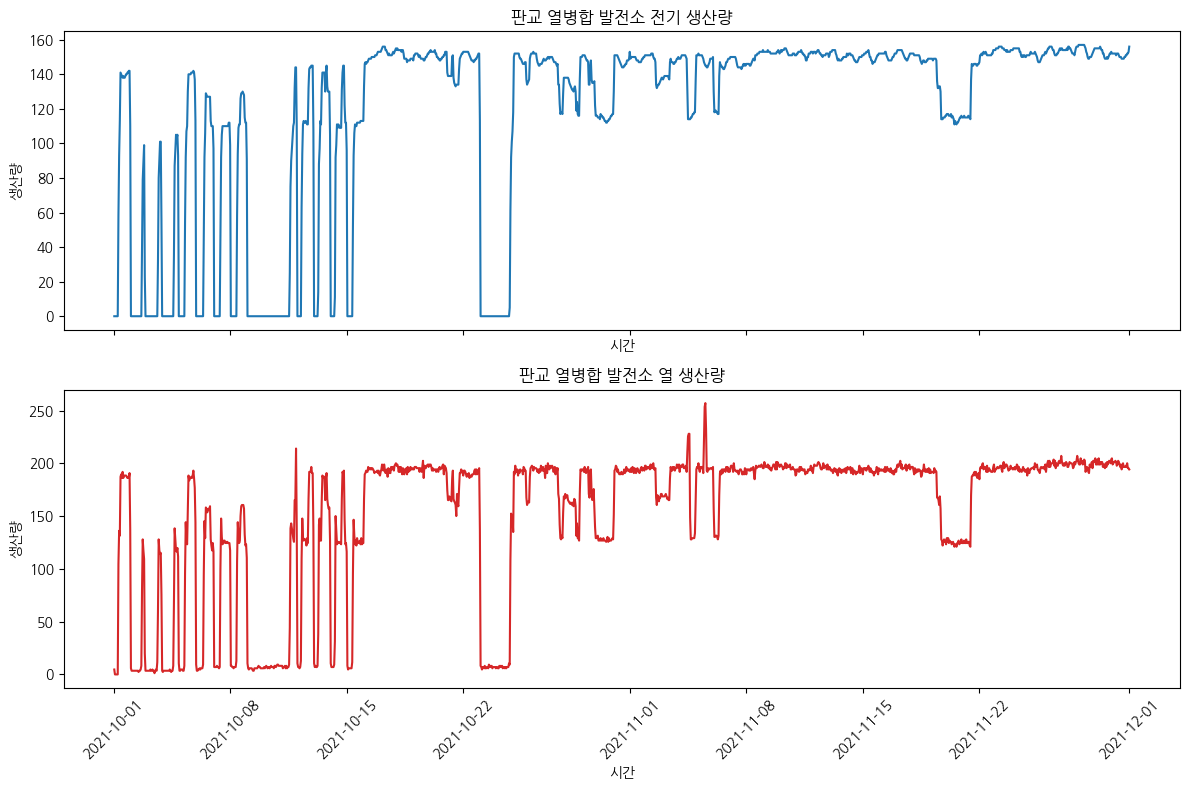

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 전기 생산량
axes[0].plot(electric_produce["판교.1"], color="tab:blue")
axes[0].set_title("판교 열병합 발전소 전기 생산량")

# 열 생산량
axes[1].plot(heat_produce["판교"]* 1.163, color="tab:red")
axes[1].set_title("판교 열병합 발전소 열 생산량")

for ax in axes:
    ax.set_xlabel("시간")
    ax.set_ylabel("생산량")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()
# 경영대학원 에너지 경제 수업

In [10]:
df_energy = pd.DataFrame({
    "heat": heat_produce["강남"], # 단위: Gcal
    "electric": electric_produce["강남.1"]  # 단위: MWh
})

# 열 생산량 단위 변환 (Gcal → MWh)
df_energy["heat_MWh"] = df_energy["heat"] * 1.163


# 시간별 총 에너지 산출량 (MWh)
df_energy["total_energy"] = df_energy["heat_MWh"] + df_energy["electric"]

# 월 컬럼 생성 (Period[M])
df_energy["month"] = df_energy.index.to_period("M")

#  월별 총 에너지 생산량 집계
monthly_energy = df_energy.groupby("month")["total_energy"].sum().rename("E_total")


# 연료 데이터 전처리 => 월 칼럼을 인식하지 못하는 경우 
if not pd.api.types.is_period_dtype(df22_filter["month"]):
    df22_filter["month"] = pd.to_datetime(df22_filter["month"]).dt.to_period("M")

fuel_gangnam = df22_filter[(df22_filter["지사"] == "강남") & (df22_filter["연료"] == "LNG")]
monthly_fuel = fuel_gangnam.set_index("month")["연료투입량"]

# 데이터 병합 (총 에너지 + 연료 사용량)
df_energy = df_energy.merge(monthly_energy, on="month", how="left")
df_energy = df_energy.merge(monthly_fuel.rename("F_Month"), on="month", how="left")

# 시간별 연료 투입량 추정치 (Nm³ 단위)
df_energy["F_hat"] = df_energy["F_Month"] * df_energy["total_energy"] / df_energy["E_total"]

# 연료 Nm³ → MWh thermal 변환
LHV = 0.0108  # LNG 저위발열량 [MWh/Nm³]
df_energy["F_hat_MWh"] = df_energy["F_hat"] * LHV

#  효율 계산
df_energy["eta_e"] = df_energy["electric"] / df_energy["F_hat_MWh"]
df_energy["eta_h"] = df_energy["heat_MWh"] / df_energy["F_hat_MWh"]
df_energy["eta_total"] = df_energy["total_energy"] / df_energy["F_hat_MWh"]

# 결과 확인
print(df_energy[[
    "heat", "electric", "heat_MWh", "total_energy",
    "F_hat", "F_hat_MWh", "eta_e", "eta_h", "eta_total"
]].head())

   heat  electric  heat_MWh  total_energy        F_hat  F_hat_MWh     eta_e  \
0  53.0      14.0    61.639        75.639  1201.422295  12.975361  1.078968   
1  52.0      14.0    60.476        74.476  1182.949627  12.775856  1.095817   
2  54.0      14.0    62.802        76.802  1219.894963  13.174866  1.062629   
3  52.0      14.0    60.476        74.476  1182.949627  12.775856  1.095817   
4  53.0      14.0    61.639        75.639  1201.422295  12.975361  1.078968   

      eta_h  eta_total  
0  4.750465   5.829433  
1  4.733616   5.829433  
2  4.766804   5.829433  
3  4.733616   5.829433  
4  4.750465   5.829433  


/tmp/ipykernel_1955220/2611141400.py:32: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if not pd.api.types.is_period_dtype(df22_filter["month"]):
/tmp/ipykernel_1955220/2611141400.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df22_filter["month"] = pd.to_datetime(df22_filter["month"]).dt.to_period("M")


---

eta_e eta_h의 비율 데이터의 값이 뭔가 이상함 %로 환산하면 100% 대로 나와버림 -> 단위 조정은 완벽하게 처리하였음. 
1. 문제는 월 단위 데이터를 증강해서 발생하는 것 같음
2. 앞에서도 설명했듯이 월간 연료 총량을 시간별 총생산 비율에 따라 단순히 나누면 즉, 전기·열 생산이 많을수록 연료를 더 쓴다고 가정한 꼴이 되어버림.
3. 그렇다면 아이디어를 하나 만들어내보자
    - CHP의 운전 효율은 0.7~0.9 범위 내에서 처리된다. - 출처 https://www.powermag.com/chp-and-district-energy-key-technologies-for-efficiency-and-grid-resilience
    - 그러면 운전 효율을 활용해보는 선에서 해결이 가능한데, 다음과 같이 식을 전개한다.
---
1. 월별 총 전기 + 열 생산량  = (Pt + Ht) = Et
2. 목표 효율을 0.8이라고 가정해보고 처음부터 수식을 풀어서 써본다.

- E_{total} = ∑​(Ht + Pt) # 열 및 전기 생산량

- 보정된 월별 연료량 [정상효율 0.8 이라고 가정했을때 연료 투입량임]
    - η_{target} = 0.8 이므로 ** F_{보정} = (E_{total} / (η_{target} * 저위발열량)) **

- 시간별 연료 증강 [이때 단위는 Nm³]
    - Ft = F_{보정} * (E_{t}/E_{total})

- 단위 변환 [Nm³ -> MWh]
    - F^(MWh)t = Ft * 저위발열량

- 동일하게 전기효율과 열 효율은 다음 공식을 따라간다.
1. 전기효율 :  Pt / 보정된 연료 투입량


2. 열 효율 : Ht / 보정된 연료 투입량

In [11]:
# -----------------------------
# 1. 목표 효율과 발열량 정의
# -----------------------------
eta_target = 0.8
HHV = 0.0115  # LNG 고위발열량 [MWh/Nm³]

# -----------------------------
# 2. 월별 보정 연료량 계산
# -----------------------------
F_corrected = monthly_energy / (eta_target * HHV)  # Nm³ 단위
df_energy = df_energy.merge(F_corrected.rename("F_corrected"), on="month", how="left")

# -----------------------------
# 3. 시간별 보정 연료 투입량 (Nm³)
# -----------------------------
df_energy["F_hat_corrected"] = (
    df_energy["F_corrected"] * df_energy["total_energy"] / df_energy["E_total"]
)

# -----------------------------
# 4. Nm³ → MWh 변환
# -----------------------------
df_energy["F_hat_corr_MWh"] = df_energy["F_hat_corrected"] * HHV

# -----------------------------
# 5. 보정된 효율 계산
# -----------------------------
df_energy["eta_e_corr"] = df_energy["electric"] / df_energy["F_hat_corr_MWh"]
df_energy["eta_h_corr"] = df_energy["heat_MWh"] / df_energy["F_hat_corr_MWh"]
df_energy["eta_total_corr"] = (
    df_energy["total_energy"] / df_energy["F_hat_corr_MWh"]
)

# -----------------------------
# 6. 결과 확인
# -----------------------------
print(df_energy[[
    "heat", "electric", "heat_MWh", "total_energy",
    "F_hat_corrected", "F_hat_corr_MWh",
    "eta_e_corr", "eta_h_corr", "eta_total_corr"
]].head())


# 그러나 이 방법은 무조건 열 효율을 0.8로 무조건 조정해야 한다.

   heat  electric  heat_MWh  total_energy  F_hat_corrected  F_hat_corr_MWh  \
0  53.0      14.0    61.639        75.639      8221.630435        94.54875   
1  52.0      14.0    60.476        74.476      8095.217391        93.09500   
2  54.0      14.0    62.802        76.802      8348.043478        96.00250   
3  52.0      14.0    60.476        74.476      8095.217391        93.09500   
4  53.0      14.0    61.639        75.639      8221.630435        94.54875   

   eta_e_corr  eta_h_corr  eta_total_corr  
0    0.148072    0.651928             0.8  
1    0.150384    0.649616             0.8  
2    0.145830    0.654170             0.8  
3    0.150384    0.649616             0.8  
4    0.148072    0.651928             0.8  


In [ ]:
## to-do
# Ut : 달라지는 지점에 확인해서 plot 그려볼것.

## 19가지 지사가 동시에 지어졌다는 가정하 전체 합 통해서 분포 확인 -> 어디는 0.5 이고 어디는 0.2 일 수 있음
### 분포 plot 확인 -> 확인해서 ..... 터빈 및 회사가 동일시점에 설립됐다는 가정하에 연구진행.
### min max ut 하에 최적운영 확인
### ut가 얼마인지? -> formula 를? 눈대중?,  한군데만 물어봐서 강남인 경우 1:9를 어떻게 계산되는지 물어보기
### 판교는?